# Multivariate Temporal Dictionary Learning for EEG
In this notebook, we reimplement experiment 1 of the article : 
Q. Barthélemy, C. Gouy-Pailler, Y. Isaac, A. Souloumiac, A. Larue, J.I. Mars,
Multivariate temporal dictionary learning for EEG,
Journal of Neuroscience Methods,
Volume 215, Issue 1,
2013,
Pages 19-28,
ISSN 0165-0270,
https://doi.org/10.1016/j.jneumeth.2013.02.001.
(https://www.sciencedirect.com/science/article/pii/S0165027013000666)

In [224]:
import numpy as np
import matplotlib.pyplot as plt
# files handling
import pickle
from os import listdir
#from os.path import exists
#from scipy.io import loadmat
import mne
from tqdm import tqdm

# Dataset

The dataset used in this experiment is dataset 2.a of the 2008 BCI competition. A description of this dataset can be found here : http://bbci.de/competition/iv/desc_2a.pdf . Although this dataset was made for a classification task, we will use it for dictionnary learning on EEG signals.

### Load dataset
For the preprocessing, we follow the article, and apply a bandwidth filter [8hz, 30Hz]. We also discard 3 channels : 'EOG-left', 'EOG-right', and 'EOG-central', as these channels are not useful to our task.

In [225]:
def load_dataset(preprocessing=True):
    train = []
    test = []
    path = './dataset/'
    items = listdir(path)
    for item in items :
        #Load session
        raw=mne.io.read_raw_gdf(path+item, verbose=False, preload=True)
        
        # Apply bandwith filter
        if preprocessing:
            raw = raw.filter(l_freq=8, h_freq=30, picks=None)
        # Convert to ndarray and discard EOG channels
        raw_eeg = raw.get_data(picks=
                                       ['EEG-Fz', 'EEG-0', 'EEG-1', 'EEG-2', 'EEG-3', 'EEG-4', 'EEG-5', 
                                        'EEG-C3', 'EEG-6', 'EEG-Cz', 'EEG-7', 'EEG-C4', 'EEG-8', 'EEG-9',
                                        'EEG-10', 'EEG-11', 'EEG-12', 'EEG-13', 'EEG-14', 'EEG-Pz', 'EEG-15', 'EEG-16'])
        # transpose to fit convention dim(signal) = (n_features, n_dims)
        raw_eeg = raw_eeg.T
        #raw_eeg.plot(n_channels=22)
        # Store in corresponding list
        if item[-5:] == 'T.gdf':
            train.append(raw_eeg)
        if item[-5:] == 'E.gdf':
            test.append(raw_eeg)
    return(train, test)

In [226]:
train, test = load_dataset(preprocessing=True)
print(train[0].shape)
print(train[0].max())
print(train[0].min())

C:\Users\Hugo\anaconda3\lib\site-packages\mne\io\edf\edf.py:1044: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
<ipython-input-225-948fa8eb8205>:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_gdf(path+item, verbose=False, preload=True)
C:\Users\Hugo\anaconda3\lib\site-packages\mne\io\edf\edf.py:1044: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, UINT8).tolist()[0]
<ipython-input-225-948fa8eb8205>:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw=mne.io.read_raw_gdf(path+item, verbose=False, preload=True)
C:\Users\Hugo\anaconda3\lib\site-packages\mne\io\edf\edf

(672528, 22)
0.0006457132104828345
-0.0006461001398773491


# Multivariate dictionary learning

In this section, we will use the multivariate dictionary learning (M-DLA) presented in the article. This algorithm is the alternation of two phases : 
- Multivariate sparse approximation, using multivariate orthogonal matching pursuit (M-OMP)
- Multivariate dictionary update, using a maximum likelihood criterion.

Sparse approximation

In [227]:
def place_in_signal(toplace, final_length, shift):
    extended_signal = np.zeros((final_length, toplace.shape[1]))
    extended_signal[shift : shift + toplace.shape[0], :] = toplace
    return extended_signal

def M_OMP(signal, compact_dict, n_nonzero_coefs, verbose=False):
    """
    Parameters:
    signal: array of shape (n_samples, n_dims)
        it's the data for one session, for one patient.
    compact_dict: list of arrays
        compact dictionary among which the members of the active
        dictionary will be chosen. Each element is a convolution kernel,
        i.e. an array of shape (k, n_dims), where k <= n_features and is
        kernel specific. The algorithm normalizes the kernels.
    n_nonzero_coefs: int
        number of non-zero coordinates in the final sparse coding
        vector.
    
    Returns:
    active_comp_dict: array of shape n_nonzero_coefs*3
        It stores the coordinates of the used kernels with the fonnowing format:
        [amplitude, offset, kernel]*n_nonzero_coefs
    residual : array of shape (n_samples, n_dims)
        residual of the reconstruction : signal - reconstruction
    
    """
    # Initialization
    n_kernels = len(compact_dict)
    k_max_len = np.max([k.shape[0] for k in compact_dict])
    k_min_len = np.min([k.shape[0] for k in compact_dict])
    n_samples, n_dims = signal.shape
    flat_signal = signal.flatten().T
    residual = signal.copy()
    # Initialize active compct dict : [amplitude, offset, kernel]*n_nonzero_coefs
    active_comp_dict = np.zeros((n_nonzero_coefs, 3)) -1
    atoms = np.zeros((n_nonzero_coefs, n_samples, n_dims))-1
    
    
    # Main loop
    for atoms_in_estimate in range(n_nonzero_coefs):
        # Compute correlations : array of size (n_kernels, max shift)
        correlation = np.zeros((n_kernels,  max(n_samples, k_max_len) - min(n_samples, k_min_len) + 1))
        for l in range(n_kernels):
            # Sum the correlations over each dimension
            corr = 0
            for dim in range(n_dims):
                corr += np.correlate(residual[:, dim], compact_dict[l][:, dim], mode='valid')
            correlation[l, :len(corr)] = corr
        
        # Select kernel to add to active dictionary
        new_kernel, new_shift = np.unravel_index(np.argmax(np.abs(correlation)), correlation.shape)
        
        # Update atoms, and flattened dictionary
        new_atom = place_in_signal(compact_dict[new_kernel], n_samples, new_shift)
        atoms[atoms_in_estimate] = new_atom
        if atoms_in_estimate == 0:
            D = new_atom.flatten().T.reshape(n_samples*n_dims, 1)
        elif atoms_in_estimate == 1:
            #D = D.flatten().T
            D = np.stack((D.flatten(), new_atom.flatten()), axis=-1)
        else:
            D = np.column_stack((D, new_atom.flatten()))

        # Compute new sparse encoding vector
        x = np.linalg.lstsq(D, flat_signal)[0]
        
        # Update compact dictionary
        active_comp_dict[atoms_in_estimate] = np.array([-1, new_shift, new_kernel])
        
        # Compute estimated signal and residual
        estimate = np.zeros((n_samples, n_dims))
        for k in range(atoms_in_estimate+1):
            estimate = estimate + x[k]*atoms[k]
        residual = signal - estimate
    # Update amplitude
    active_comp_dict[:, 0] = x
    
    if verbose:
        print("x", x)
        print("x.shape", x.shape)
        print("active_comp_dict", active_comp_dict)
        print("residual", residual)
    return active_comp_dict, residual

### Dictionary update

In [711]:
def dictionary_update(dictionary, decomposition, residual, learning_rate=0):
    """
    Update the dictionary according to the stochastic gradient
    descent/Newton method 
    
    ----------
    
    dictionary: list of arrays
        The dictionary against which to solve the sparse coding of
        the data. The dictionary learned is a list of n_kernels
        elements. Each element is a convolution kernel, i.e. an
        array of shape (k, n_dims), where k <= n_features and is
        kernel specific. The algorithm normalizes the kernels.
        
    decomposition: array of shape (n_features, 3)
        One row of the decomposition array is composed as such:
        [coefficient, temporal shift, kernel_index]
        
    residual: array of shape (n_features,n_dims)
        Residual of the sparse decomposition
        
    learning_rate: real
        hyperparameter controling the convergence rate. Is defined in 
        the outer function _learning_rate
        

    Returns
    -------
    dictionary: list of arrays
        Updated dictionary of kernels.
        
    """
    
    #Initialization
    n_kernels = len(dictionary)

    n_active_atoms = decomposition.shape[0]
    signal_len, n_dims = residual.shape
    amplitudes = decomposition[:, 0]
    offsets = decomposition[:, 1].astype(int)
    indexes = decomposition[:, 2].astype(int)
    H_sum = 0
    H_count = 0

    
    gradient = [np.zeros_like(dictionary[i]) for i in range(n_kernels)]

    for i in range(n_active_atoms):
        k_len = dictionary[indexes[i]].shape[0]
        if k_len + offsets[i]  < signal_len:
            # Do not consider oversized atoms
            r = residual[offsets[i] : k_len + offsets[i], :]  # modif
            gradient[indexes[i]] += np.conj(amplitudes[i] * r)

    
    step = np.zeros((n_kernels, 1))
    for i in range(n_kernels):
        k_len = dictionary[i].shape[0]
        kernel_indexes = np.where(indexes == i)[0]
        
        #get sorted offsets
        kernel_offsets = offsets[kernel_indexes]
        sorted_kernel_offsets = np.sort(kernel_offsets)
        proper_order = np.argsort(kernel_offsets)
        
        #get sorted amplitudes
        kernel_amplitudes = amplitudes[kernel_indexes]
        sorted_kernel_amplitudes = kernel_amplitudes[proper_order]
        
        #Find self overlapping kernels
        diff_offsets = sorted_kernel_offsets[1:] - sorted_kernel_offsets[:-1]
        overlapping = np.where(diff_offsets>k_len)[0]
        
        #Computation of the upper born of the correlation terms of the Hessian
        if np.sum(overlapping) == 0:
            H_corr = 0
        else:                  
            H_corr = (
                2.0
                * np.sum(
                    np.abs(kernel_amplitudes[overlapping] * kernel_amplitudes[overlapping + 1])
                    * (k_len - diff_offsets[overlapping])
                )
                / k_len
            )
            
        
        H_base = np.sum(np.abs(amplitudes[kernel_indexes]) ** 2)
        
        #Computing the step which is a function of the learning rate
        if learning_rate == 0.0:
            step[i] = 0
        else:
            step[i] = 1.0 / (learning_rate + H_corr + H_base)
        if (H_corr + H_base) != 0:
            H_sum += H_corr + H_base
            H_count += 1

    gradient = [gradient[i] * step[i] for i in range(n_kernels)]
    
    ########
    #Dictionary update
    ########
    for i in range(len(dictionary)):
        dictionary[i] = dictionary[i] + gradient[i]
        
    #######
    #Normalize dictionary
    #######
    for i in range(len(dictionary)):
        dictionary[i] = dictionary[i]/np.linalg.norm(dictionary[i], "fro")

    return dictionary


def calculate_residuals(signal,dictionary,decomposition):
    """
    Compute the reconstruction of the signal with the 
    sparse coding and the dictionary, as well as the 
    residuals
    
    ----------
    
    signal: Array of shape (n_features, n_dims)
        The signal against which the dictionary is learnt
    
    dictionary: list of arrays
        The dictionary of kernels. Each element is a 
        convolution kernel, i.e. an array of shape 
        (k, n_dims), where k <= n_features and is kernel 
        specific. The algorithm normalizes the kernels.
        
    decomposition: array of shape (n_features, 3)
        One row of the decomposition array is composed as such:
        [coefficient, temporal shift, kernel_index]
        
    ----------
    returns the reconstruction and the residuals
        
    """
    recomp = np.zeros(signal.shape)
    for i in range(decomposition.shape[0]):
        y_add = np.zeros(signal.shape)
        amplitude = decomposition[i, 0]
        offset = decomposition[i,1].astype(int)
        idx = decomposition[i,2].astype(int)
        k_len = dictionary[idx].shape[0]
        y_add[offset : k_len + offset, :] = amplitude*dictionary[idx]
        recomp+=y_add

    return recomp, signal - recomp

def reconstruction_rate(signal, residuals):
    '''
    returns the reconstruction and the residuals
    '''
    return(1 - np.linalg.norm(residuals)/np.linalg.norm(signal))

def _learning_rate(iteration, max_iteration,learning_rate):
    '''
    returns the learning rate according
    to the heuristic.
    '''
    if learning_rate == 0:
        return 0.0
    ceiling = np.floor(max_iteration*2/3)
    if iteration >=ceiling:
        return ceiling*learning_rate
    else:
        return iteration*learning_rate


# Experiments

## First experiment

In [612]:
train_small, test_small = train[0][:500,:5], test[0][:500,:5]

In [703]:
#Initialization of the hyperparameters
signal = train_small
compact_dict = [np.random.rand(n, 5) for n in [20,60,150,230,350]]
# compact_dict = [np.random.rand(100, 5) for i in range(1,2)]
n_nonzero_coefs = 60
max_iteration = 30
learning_rate = 1

#Dictionary Learning
for iteration in tqdm(range(max_iteration)):
    
    learning_rate = _learning_rate(iteration, max_iteration,learning_rate)
    decomposition, residuals = M_OMP(signal, compact_dict, n_nonzero_coefs)
    compact_dict = dictionary_update(compact_dict, decomposition, residuals, learning_rate=learning_rate)

  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.77it/s]


In [704]:
recomp, residuals_finals = calculate_residuals(signal,compact_dict,decomposition)

In [705]:
reconstruction_rate(signal, residuals_finals)

0.36862663115548766

Text(0.5, 1.0, 'Channel 0 reconstructed')

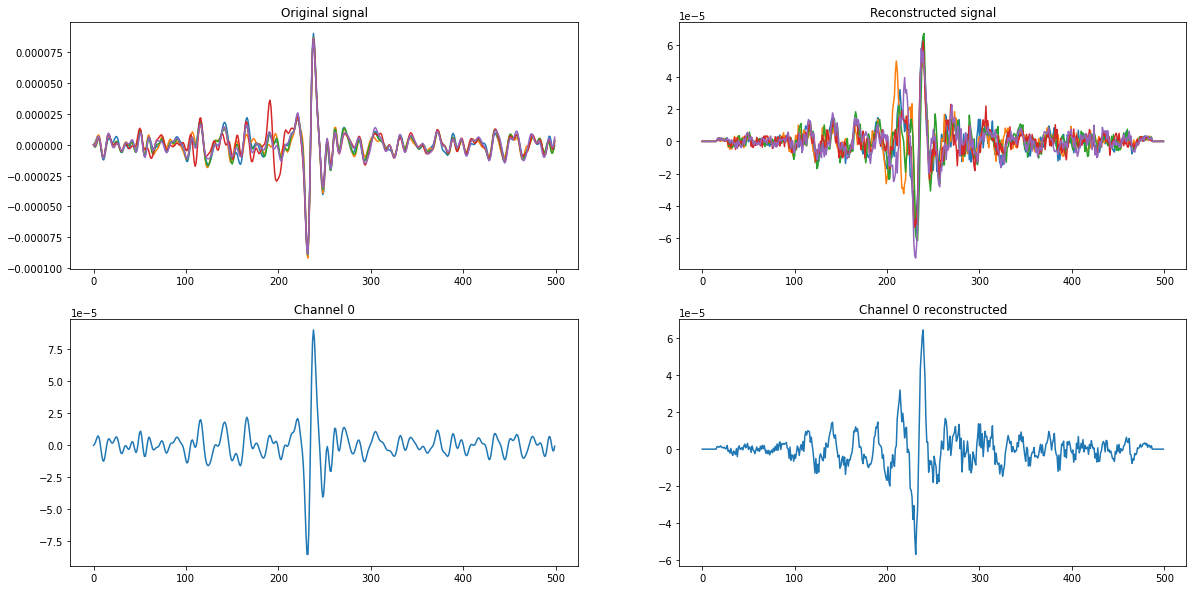

In [702]:
fig, axs = plt.subplots(2,2, figsize = (20,10))
axs[0,0].plot(signal)
axs[0,0].set_title('Original signal')

axs[0,1].plot(recomp)
axs[0,1].set_title('Reconstructed signal')

axs[1,0].plot(signal[:,0])
axs[1,0].set_title('Channel 0')

axs[1,1].plot(recomp[:,0])
axs[1,1].set_title('Channel 0 reconstructed')

## Activation and kernel visualisation

In [691]:
def visualise(compact_dict, decomposition, kernel):
    '''
    Visualise the histograms of the kernel used,
    its activations in the reconstructions,
    the padded and unpadded version of the 
    kernel
    '''
    
    #find activations
    activations = decomposition[decomposition[:,2] == kernel,1].astype(int)
    diracs = np.zeros((train_small.shape[0],1))
    diracs[activations] = 1
    
    #pad around the kernel   
    kernel_padded = np.zeros(train_small.shape)
    kernel_padded[:compact_dict[kernel].shape[0],:] = compact_dict[kernel]
    
    
    #Plot the different figures
    fig, axs = plt.subplots(2,2, figsize = (20,8))

    axs[0,0].hist(decomposition[:,2].astype(int), bins=100)
    axs[0,0].set_title('Dictionary usage')
    
    axs[0,1].plot(diracs)
    axs[0,1].set_title('Kernel {} activation'.format(kernel))
    axs[0,1].set_ylim([0.5,1.5])
    
    axs[1,0].plot(kernel_padded)
    axs[1,0].set_title('Kernel {} visualisation (padded)'.format(kernel))
    
    axs[1,1].plot(compact_dict[kernel])
    axs[1,1].set_title('Kernel {} visualisation (non padded)'.format(kernel))
    
    
    

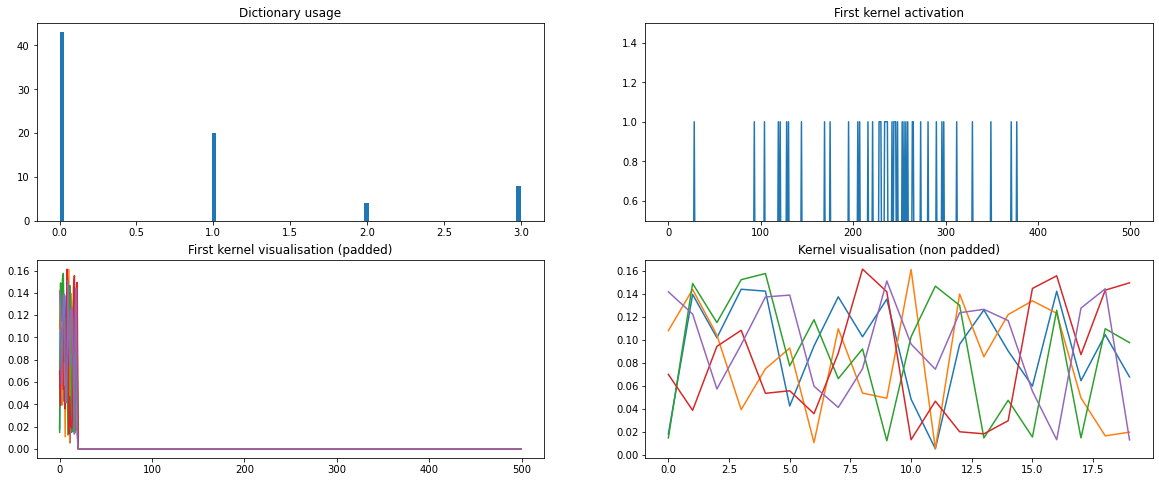

In [692]:
visualise(compact_dict, decomposition, 0)

## Partial reconstruction

In [712]:
kernel = 0
recomp_partial, residuals_finals = calculate_residuals(signal,compact_dict,decomposition[decomposition[:,2] == kernel])

Text(0.5, 1.0, 'Reconstructed signal with only first atom')

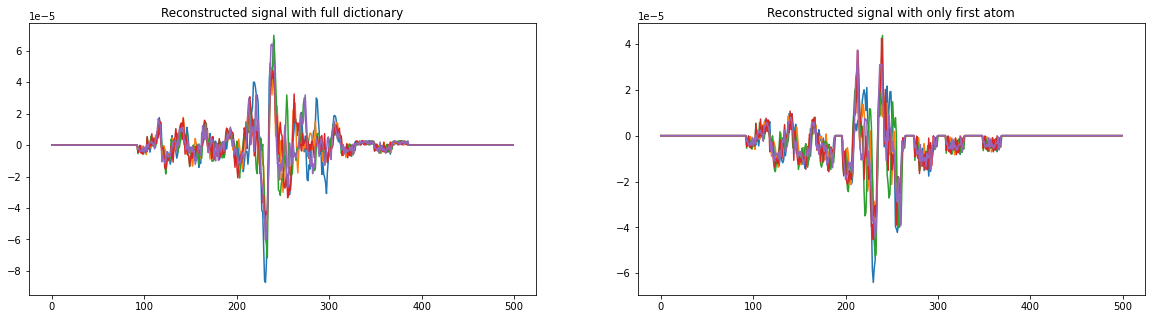

In [713]:
fig, axs = plt.subplots(1,2, figsize = (20,5))

axs[0].plot(recomp)
axs[0].set_title('Reconstructed signal with full dictionary')

axs[1].plot(recomp_partial)
axs[1].set_title('Reconstructed signal with only first atom')

In [708]:
reconstruction_rate(signal, residuals_finals)

0.18638549287696216

## Second experiment

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\viniv\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  7.78it/s]


reconstruction rate: 0.4237387359671203


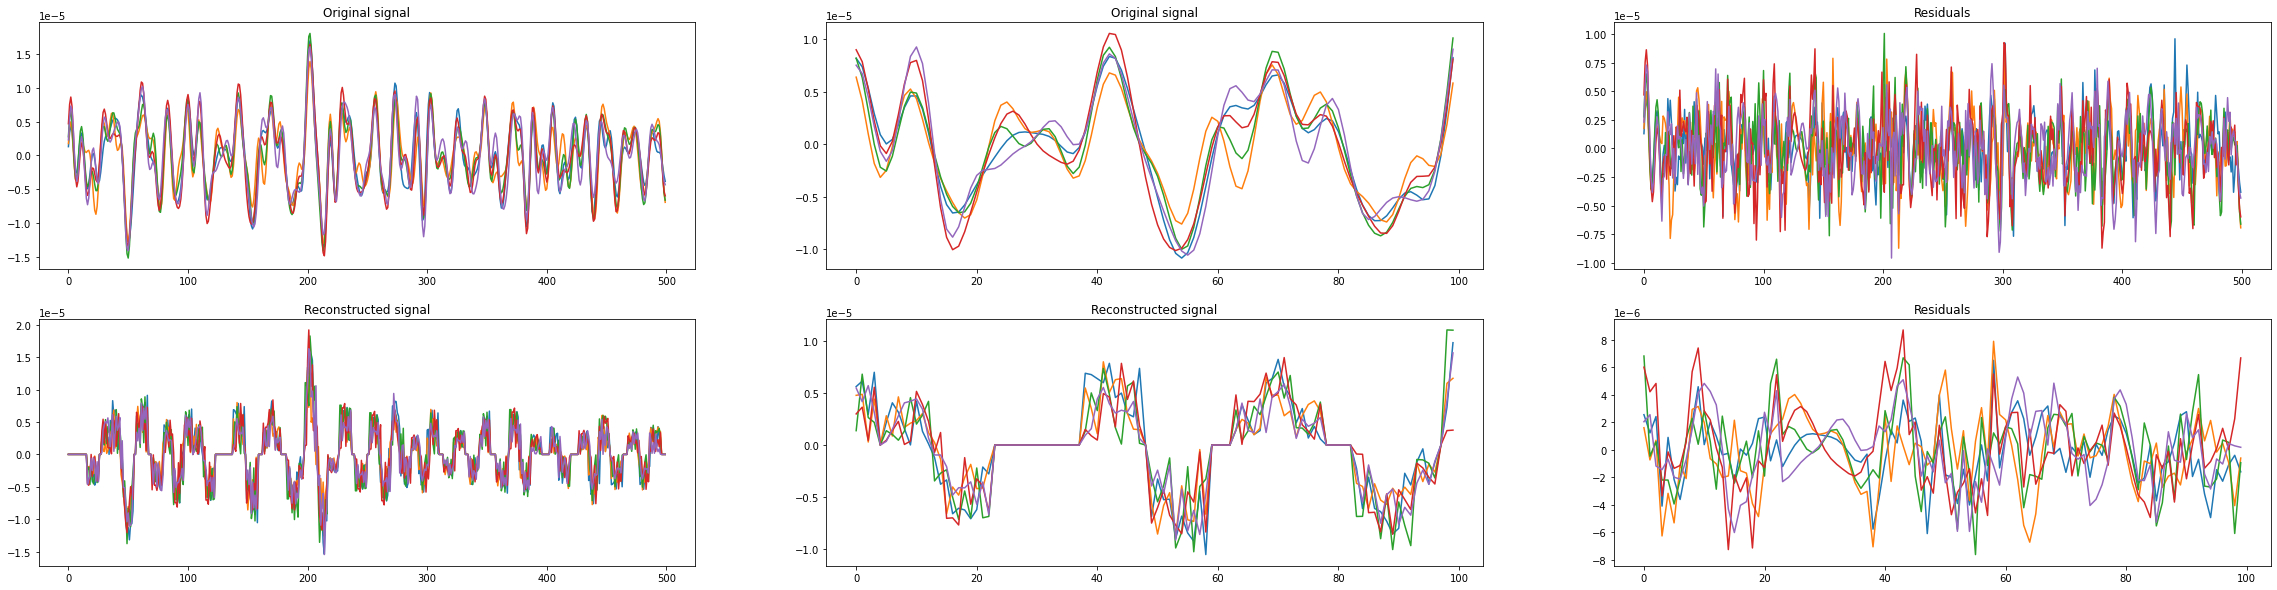

In [528]:
signal = train[0][100000:100500, :5]
compact_dict = [np.random.rand(10, 5) for _ in range(1,30)]
n_nonzero_coefs = 50  # 50
max_iteration = 100
learning_rate = 1

for iteration in tqdm(range(max_iteration)):
    
    learning_rate = _learning_rate(iteration, max_iteration,learning_rate)
    decomposition, residuals = M_OMP(signal, compact_dict, n_nonzero_coefs)
    compact_dict = dictionary_update(compact_dict, decomposition, residuals, learning_rate=learning_rate)
    recomp, residuals_finals = calculate_residuals(signal,compact_dict,decomposition)
rec_rate = reconstruction_rate(signal, residuals_finals)

print("reconstruction rate:", rec_rate)
fig, axs = plt.subplots(2,3, figsize = (40,10))
axs[0, 0].plot(signal)
axs[0, 0].set_title('Original signal')

axs[1, 0].plot(recomp)
axs[1, 0].set_title('Reconstructed signal')

axs[0, 2].plot(residuals)
axs[0, 2].set_title('Residuals')

axs[0, 1].plot(signal[100:200, :])
axs[0, 1].set_title('Original signal')

axs[1, 1].plot(recomp[100:200, :])
axs[1, 1].set_title('Reconstructed signal')

axs[1, 2].plot(residuals[100:200, :])
axs[1, 2].set_title('Residuals')
plt.show()
#print('decomposition', decomposition)

# Toy Signal

### Creation of the signal

In [619]:
def triangle(x):
    return 0.1*x

In [717]:
band = np.arange(100)

signal = np.zeros((500,2))
signal[100:200,0] = 10
signal[100:200,1] = triangle(band)

signal[300:400,1] = 10
signal[300:400,0] = triangle(band)


### Plot the two channels

Text(0.5, 1.0, 'Channel 2')

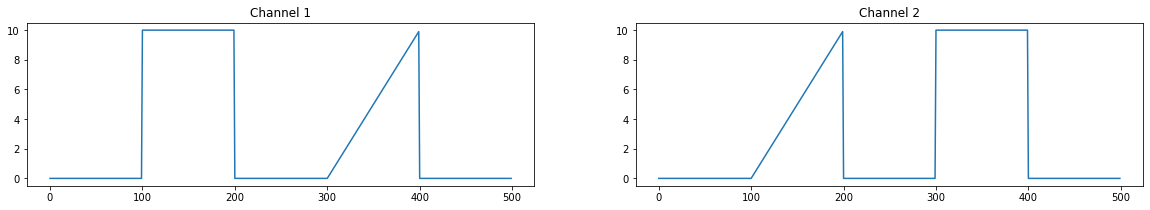

In [718]:
fig, axs = plt.subplots(1,2, figsize = (20,3))

axs[0].plot(signal[:,0])
axs[0].set_title('Channel 1')

axs[1].plot(signal[:,1])
axs[1].set_title('Channel 2')

### Dictionary learning

In [650]:
compact_dict = [np.random.rand(50, 2) for _ in range(10)]
n_nonzero_coefs = 100
max_iteration = 10
learning_rate = 1

for iteration in tqdm(range(max_iteration)):
    
    learning_rate = _learning_rate(iteration, max_iteration,learning_rate)
    decomposition, residuals = M_OMP(signal, compact_dict, n_nonzero_coefs)
    compact_dict = dictionary_update(compact_dict, decomposition, residuals, learning_rate=learning_rate)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\Hugo\anaconda3\lib\site-packages\ipykernel_launcher.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.53it/s]


### Reconstruction and visualisation

In [651]:
recomp, residuals_finals = calculate_residuals(signal,compact_dict,decomposition)

Text(0.5, 1.0, 'Residuals')

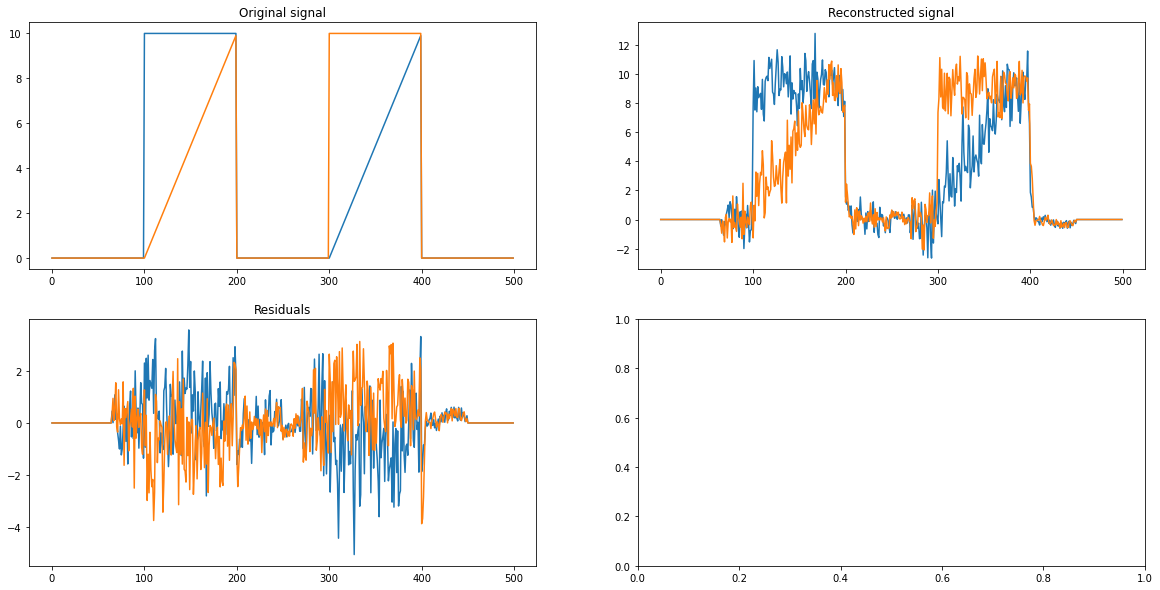

In [652]:
fig, axs = plt.subplots(2,2, figsize = (20,10))
axs[0,0].plot(signal)
axs[0,0].set_title('Original signal')

axs[0,1].plot(recomp)
axs[0,1].set_title('Reconstructed signal')


### Kernel activations

In [653]:
def visualise(compact_dict, decomposition, kernel):
    
    #find activations
    activations = decomposition[decomposition[:,2] == kernel,1].astype(int)
    diracs = np.zeros((signal.shape[0],1))
    diracs[activations] = 1
    
    #pad around the kernel   
    kernel_padded = np.zeros(signal.shape)
    kernel_padded[:compact_dict[kernel].shape[0],:] = compact_dict[kernel]
    
    
    fig, axs = plt.subplots(2,2, figsize = (20,5))

    axs[0,0].hist(decomposition[:,2].astype(int), bins=100)
    axs[0,0].set_title('Kernel repartition (multiply by 20 to get kernel length)')
    
    axs[1,0].plot(kernel_padded)
    axs[1,0].set_title('Kernel visualisation')
    
    axs[1,1].plot(diracs)
    axs[1,1].set_title('Kernel activations')
    axs[1,1].set_ylim([0.5,1.5])
    

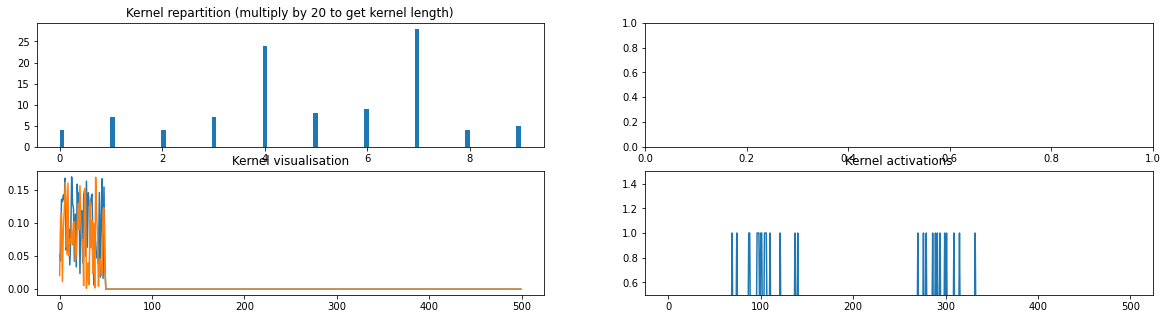

In [656]:
visualise(compact_dict, decomposition, 7)